In [2]:
!pip install hazm

In [7]:
import pandas as pd
import re
import string
import tqdm
import hazm
import random
import itertools
from nltk import FreqDist
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# df = pd.read_csv("/content/drive/MyDrive/NLP_HW2_Data/digikala_comments.csv", usecols=['recommend', 'comment'], skipinitialspace=True, na_values={'recommend': [r'\N', 'no_idea']}, encoding='utf-8')
df = pd.read_csv("digikala_comments.csv", usecols=['recommend', 'comment'], skipinitialspace=True, na_values={'recommend': [r'\N', 'no_idea']}, encoding='utf-8') 
df = df[df["recommend"].notna()]
df = df.reset_index(drop=True)
df

,recommend,comment
0,recommended,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...
1,not_recommended,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...
2,recommended,سلام دوستان،،\r\nمنم مثه بعضی از دوستان قبل از...
3,recommended,من چند سالی هست که این اسپیکرو خریدم و واقعا ح...
4,recommended,نزدیک به دو ساله که این هارد رو خریدم. استفاده...
...,...,...
53077,not_recommended,کاملابی کیفیت، تو هر قیمتی اصلا ارزش خرید نداره
53078,recommended,عالیییییییییییییییییییی
53079,not_recommended,اندازه بالش بسیار کوچک هست بیشتر بدرد بچه ۲ سا...
53080,recommended,بسیار تمیز و زیبا...من که خیلی راضیم


In [ ]:
df["recommend"] = df["recommend"].astype("category").cat.codes
df

,recommend,comment
0,1,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...
1,0,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...
2,1,سلام دوستان،،\r\nمنم مثه بعضی از دوستان قبل از...
3,1,من چند سالی هست که این اسپیکرو خریدم و واقعا ح...
4,1,نزدیک به دو ساله که این هارد رو خریدم. استفاده...
...,...,...
53077,0,کاملابی کیفیت، تو هر قیمتی اصلا ارزش خرید نداره
53078,1,عالیییییییییییییییییییی
53079,0,اندازه بالش بسیار کوچک هست بیشتر بدرد بچه ۲ سا...
53080,1,بسیار تمیز و زیبا...من که خیلی راضیم


1    36972
0    16110
Name: recommend, dtype: int64


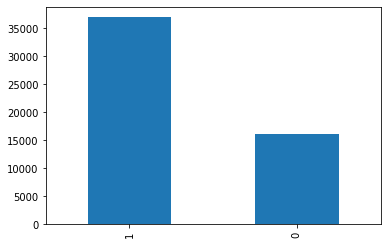

In [ ]:
recommend_count_values = df["recommend"].value_counts()
recommend_count_values.plot(
    kind = 'bar'
)
print(recommend_count_values)

In [ ]:
recom = df[df["recommend"]==1].values
recom_test_data = recom[:1000]
recom = recom[1000:]
notrecom = df[df["recommend"]==0].values
notrecom_test_data = notrecom[:1000]
notrecom = notrecom[1000:]
notrecom = np.append(notrecom, notrecom, axis=0)
dup_idx = np.random.randint(len(notrecom), size=len(recom)-len(notrecom))
notrecom = np.append(notrecom, notrecom[dup_idx], axis=0)
balanced = np.vstack((recom, notrecom))
balanced_df = pd.DataFrame(balanced, columns=["recommend", "comment"])
test = np.vstack((recom_test_data, notrecom_test_data))
test_df = pd.DataFrame(test, columns=["recommend", "comment"])

1    35972
0    35972
Name: recommend, dtype: int64


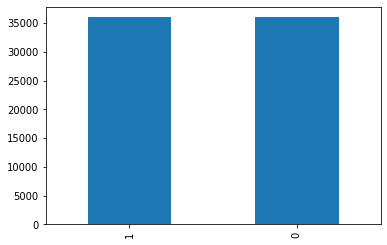

In [ ]:
print(balanced_df["recommend"].value_counts())
balanced_df["recommend"].value_counts().plot(
    kind = "bar"
)

In [ ]:
def remove_nonword(s):
    return re.sub(r"[^\w\s]|[a-z]|[A-Z]", " ", s)

In [ ]:
def remove_digits(s):
    return re.sub(r"\d", "", s)

In [ ]:
def remove_ws(s):
    return re.sub(r"\n|\r|\t", "", s)

In [ ]:
def remove_punctuation(s):
    return "".join([char for char in s if char not in string.punctuation])

In [ ]:
def remove_elongation(s):
    return re.sub(r'(.)\1+', r'\1', s)

In [ ]:
def dummy_preprocess(s):
    s = remove_nonword(s)
    s = remove_digits(s)
    s = remove_ws(s)
    s = remove_elongation(s)
    s = remove_punctuation(s)
    return s

In [ ]:
preprocessed_comment = []
for idx, row in balanced_df.iterrows():
    try:
        preprocessed_comment.append(dummy_preprocess(row["comment"]))
    except:
        balanced_df.drop(idx, inplace=True)

In [ ]:
preprocessed_comment_test = []
for idx, row in test_df.iterrows():
    try:
        preprocessed_comment_test.append(dummy_preprocess(row["comment"]))
    except:
        test_df.drop(idx, inplace=True)

# Normalizing

In [ ]:
normalizer = hazm.Normalizer()
normalized_comments = [[normalizer.normalize(word) for word in comment.split()] for comment in tqdm.tqdm(preprocessed_comment)]
normalized_comments_test = [[normalizer.normalize(word) for word in comment.split()] for comment in tqdm.tqdm(preprocessed_comment_test)]

100%|██████████| 1999/1999 [00:01<00:00, 1201.12it/s]


In [ ]:
for c in random.sample(normalized_comments, 10):
    print(' '.join(c), end=f"\n{'-'*100}\n")

نورش در حد یک لامپ وات نیست حدود وات بیشتر نیست ارزش خرید نداره
----------------------------------------------------------------------------------------------------
واقعا مسخرست از فروشگاه بامین به اسم قاب سیلیکونی خریدم ولی یه قاب ژله ای شل و وا رفته که اصلا ارزش نداره واسم آوردن متاسفم برای دیجی کالا که دیگه نظارتی نداره
----------------------------------------------------------------------------------------------------
چند وقتیه خریدم واقعا رازیم ازش تو دست خوب جلوه میکنه
----------------------------------------------------------------------------------------------------
برخلاف نظرات ثبت شده عالی
----------------------------------------------------------------------------------------------------
اصلا بوی خاصی استشمام نمیشود و ماندگاری هم ندارد
----------------------------------------------------------------------------------------------------
شغل من فنی هستش بسیار شمع خوبیه
----------------------------------------------------------------------------------------------------
بوی گرم و

#Tokenization

In [ ]:
normalized_comments = [' '.join(comment) for comment in normalized_comments]
normalized_comments_test = [' '.join(comment) for comment in normalized_comments_test]
comments_tokens = [hazm.word_tokenize(comment) for comment in tqdm.tqdm(normalized_comments)]
comments_tokens_test = [hazm.word_tokenize(comment) for comment in tqdm.tqdm(normalized_comments_test)]

100%|██████████| 1999/1999 [00:00<00:00, 28429.07it/s]


#Adjusting hazm stop-words

In [5]:
# with open("/content/drive/MyDrive/NLP_HW2_Data/comments_frequent_tokens.txt", "w") as file:
#     for token, _ in FreqDist(list(itertools.chain(*comments_tokens))).most_common(100):
#         file.write(token+'\n')

# with open("/content/drive/MyDrive/NLP_HW2_Data/fa_stopwords.txt") as stopwords_file:    
#     stopwords = stopwords_file.read().split()
# with open("/content/drive/MyDrive/NLP_HW2_Data/fa_stopwords.txt", "a") as stopwords_file:    
#     try:
#         with open("/content/drive/MyDrive/NLP_HW2_Data/comments_frequent_tokens_reviewed.txt", "r") as frequent_tokens:
#             for token in frequent_tokens:
#                 if token.strip() not in stopwords:
#                     stopwords_file.write(token)
#     except:
#         with open("/content/drive/MyDrive/NLP_HW2_Data/comments_frequent_tokens.txt", "r") as frequent_tokens:
#             for token in frequent_tokens:
#                 if token.strip() not in stopwords:
#                     stopwords_file.write(token+'\n')

with open("fa_stopwords.txt") as stopwords_file:    
# with open("/content/drive/MyDrive/NLP_HW2_Data/fa_stopwords.txt") as stopwords_file:    
    stopwords = stopwords_file.read().split()

#Removing stop-words

In [ ]:
nonstop_comments_tokens = [[token for token in comment if token not in stopwords] for comment in tqdm.tqdm(comments_tokens)]
nonstop_comments_tokens_test = [[token for token in comment if token not in stopwords] for comment in tqdm.tqdm(comments_tokens_test)]

100%|██████████| 1999/1999 [00:00<00:00, 5093.22it/s]


# Lemmatization 
* it seems that it is not a proper startegy. 

In [ ]:
lemmatizer = hazm.Lemmatizer()

In [ ]:
lemmatized_tokens = [[lemmatizer.lemmatize(token) for token in comment] for comment in tqdm.tqdm(nonstop_comments_tokens)]
lemmatized_tokens_test = [[lemmatizer.lemmatize(token) for token in comment] for comment in tqdm.tqdm(nonstop_comments_tokens_test)]

100%|██████████| 1999/1999 [00:00<00:00, 31388.43it/s]


In [ ]:
for c in random.sample(lemmatized_tokens, 10):
    print(' '.join(c), end=f"\n{'-'*100}\n")

مدل ارزان قیمته انتظار مشکل سیم کارت نم خوند سیم کارت تماس منتظر مرجوع شه برد#بر معتبر تر پیشنهاد میدم مثلا سامسونگ رده مشکل اکثر سالم
----------------------------------------------------------------------------------------------------
صدا محیط کنه طوری نمیشه شنید#شنو واسه درس خوندن استفاده عالیه
----------------------------------------------------------------------------------------------------
کیف پیشنهاذ پشیمونم کیفیت نا مرغوب استفاده برام
----------------------------------------------------------------------------------------------------
حد نصب سختی مکافات انداخت#انداز خواست#خواه روز برش داشت#دار بامپر تمامه
----------------------------------------------------------------------------------------------------
طرح لباس عکس کوچیکه
----------------------------------------------------------------------------------------------------
اینو خریدمهم خوشگله سایز جنس خوبهاستند
----------------------------------------------------------------------------------------------------
کیفیت نامرغوب استف

In [ ]:
lemmatized_tokens = [[token for token in comment if '#' not in token] for comment in tqdm.tqdm(lemmatized_tokens)]
lemmatized_tokens_test = [[token for token in comment if '#' not in token] for comment in tqdm.tqdm(lemmatized_tokens_test)]

100%|██████████| 1999/1999 [00:00<00:00, 425345.66it/s]


In [ ]:
for c in random.sample(lemmatized_tokens, 10):
    print(' '.join(c), end=f"\n{'-'*100}\n")

بو آزار دهنده میشد ارفاق تحمل
----------------------------------------------------------------------------------------------------
کیفیت شستن کوچیک
----------------------------------------------------------------------------------------------------
ارزش
----------------------------------------------------------------------------------------------------
کیفیت انتظار مرغوب تر تحویل
----------------------------------------------------------------------------------------------------
تازه خریدمش گزینه بخار پز برنج استفاده راضیم خصوصا ته دیگ درست
----------------------------------------------------------------------------------------------------
کاور زبره سمباده دون دونه شه دستون لیز نخوره دستشون عرق کنه اکثر کاور خشک سیلیکون دکمه صدا نم پوشونه پاین گوشیو حد پوشونه خوب اینه دسترس شارژر جک هدفون مشکل ندارین صدا اسپیکر کیفیت میکروفون نم کنه بد اینه زوایا خاص زمین بخوره مکنه آسیب بینه یکم بالاس راضی پیشنهاد
----------------------------------------------------------------------------------------

#Stemming

In [ ]:
# stemmer = hazm.Stemmer()
# stemmed_tokens = [[stemmer.stem(token) for token in comment] for comment in tqdm.tqdm(nonstop_comments_tokens)]

In [ ]:
# for c in random.sample(stemmed_tokens, 10):
#     print(' '.join(c), end=f"\n{'-'*100}\n")

In [ ]:
# for c in random.sample(nonstop_comments_tokens, 10):
#     print(' '.join(c), end=f"\n{'-'*100}\n")

#Creating vocab

In [ ]:
# itos
itos = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]
itos.extend(list(set(itertools.chain(*nonstop_comments_tokens))))
itos.extend(list(set(itertools.chain(*nonstop_comments_tokens_test))))
itos = list(set(itos))
# stoi
stoi = {token: idx for idx, token in enumerate(itos)}

In [ ]:
lengths = np.array([len(comment) for comment in nonstop_comments_tokens])
print(np.median(lengths))
print(np.mean(lengths))


8.0
12.31018801802303


In [ ]:
seq_len = 10

In [ ]:
def encode_pad(comment, length):
    sos = [stoi["<SOS>"]]
    eos = [stoi["<EOS>"]]
    pad = [stoi["<PAD>"]]
    unk = [stoi["<UNK>"]]
    if len(comment) < length-2:
        n_pads = length-2-len(comment)
        encoded = [stoi.get(token, 3) for token in comment]
        return sos + encoded + eos + pad*n_pads
    else:
        encoded = [stoi.get(token, 3) for token in comment]
        truncated = encoded[:length-2]
        return sos + truncated + eos

In [ ]:
encoded_comments = [encode_pad(comment, seq_len) for comment in nonstop_comments_tokens]
encoded_comments_test = [encode_pad(comment, seq_len) for comment in nonstop_comments_tokens_test]

labels = balanced_df["recommend"].values
labels_test = test_df["recommend"].values

train_x = np.array(encoded_comments)
train_y = labels.astype(int)
test_x = np.array(encoded_comments_test)
test_y = labels_test.astype(int)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y).type(torch.float))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y).type(torch.float))

train_loader = DataLoader(train_ds, shuffle=True, batch_size=50, drop_last = True)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=50, drop_last=True)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded)
        out = self.dropout(out)
        out = self.fc(out)
        out = out[:, -1]
        out = self.sigmoid(out)
        return out

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded)
        out = self.dropout(out)
        out = self.fc(out)
        out = out[:, -1]
        out = self.sigmoid(out)
        return out

In [ ]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.gru(embedded)
        out = self.dropout(out)
        out = self.fc(out)
        out = out[:, -1]
        out = self.sigmoid(out)
        return out


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device.")

model_lstm = LSTM(len(stoi), 100, 8, 0.5)
model_lstm = model_lstm.to(device)

model_rnn = RNN(len(stoi), 64, 32, 0.3)
model_rnn = model_rnn.to(device)

model_gru = GRU(len(stoi), 64, 32, 0.3)
model_gru = model_gru.to(device)

model = model_lstm
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Using cuda device.


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    n_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X).flatten()
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch+1) % 50 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f} | [{current:>5d}/{size:>5d}]")
        
    train_loss /= n_batches
    return train_loss

    return loss
def eval(dataloader, model, loss_fn):
    n_batches = len(dataloader)
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).flatten()
            eval_loss += loss_fn(pred, y).item()
    eval_loss /= n_batches
    print(f"Eval Error: \n Avg loss: {eval_loss:>8f} \n")
    return eval_loss

In [ ]:
n_epochs = 50
val_losses = []
train_losses = []
for e in range(n_epochs):
    print(f"Epoch {e+1}\n{'-'*40}")
    train_loss = train(train_loader, model, criterion, optimizer)
    val_loss = eval(test_loader, model, criterion)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
    if val_loss > 0.6 and train_loss <0.3:
        break

Epoch 1
----------------------------------------
loss: 0.682087 | [ 2500/71908]
loss: 0.715048 | [ 5000/71908]
loss: 0.701735 | [ 7500/71908]
loss: 0.727897 | [10000/71908]
loss: 0.668807 | [12500/71908]
loss: 0.701063 | [15000/71908]
loss: 0.711088 | [17500/71908]
loss: 0.659073 | [20000/71908]
loss: 0.714061 | [22500/71908]
loss: 0.653307 | [25000/71908]
loss: 0.641331 | [27500/71908]
loss: 0.629296 | [30000/71908]
loss: 0.568188 | [32500/71908]
loss: 0.632466 | [35000/71908]
loss: 0.505164 | [37500/71908]
loss: 0.429548 | [40000/71908]
loss: 0.540984 | [42500/71908]
loss: 0.536248 | [45000/71908]
loss: 0.562815 | [47500/71908]
loss: 0.433371 | [50000/71908]
loss: 0.451902 | [52500/71908]
loss: 0.491189 | [55000/71908]
loss: 0.511015 | [57500/71908]
loss: 0.494495 | [60000/71908]
loss: 0.582683 | [62500/71908]
loss: 0.551893 | [65000/71908]
loss: 0.585357 | [67500/71908]
loss: 0.450725 | [70000/71908]
Eval Error: 
 Avg loss: 0.573382 

Epoch 2
----------------------------------------

In [ ]:
import plotly.express as px

fig = px.line(x=range(1, len(val_losses)+1), y=[train_losses, val_losses])
fig.show()

In [ ]:
def comment_to_tensor(comments):
    crawled_comments = [dummy_preprocess(comment) for comment in comments]
    norm_crw_comments = [[normalizer.normalize(word) for word in comment] for comment in crawled_comments]
    crw_tokens = [hazm.word_tokenize(' '.join(comment)) for comment in norm_crw_comments]
    nonstop_crw_tokens = [[token for token in comment if token not in stopwords] for comment in crw_tokens]
    lemmatized_crw_tokens = [[lemmatizer.lemmatize(token) for token in comment] for comment in nonstop_crw_tokens]
    lemmatized_crw_tokens = [[token for token in comment if '#' not in token] for comment in lemmatized_crw_tokens]
    encoded_crw_comments = [encode_pad(comment, seq_len) for comment in lemmatized_crw_tokens]
    X = torch.Tensor(encoded_crw_comments).type(torch.int)
    return X

In [ ]:
comments = ["خیلی خوبه.", "به درد نمی‌خوره. پیشنهاد نمی‌کنم", "افتضاحه", "عالیه", "حتما بخرید. خیلی خوبه. عالیه. پیشنهاد می‌کنم.", "فوق العاده است."]
X = comment_to_tensor(comments)
df = pd.DataFrame({"Comments": comments})

In [ ]:
recommendations = []
with torch.no_grad():
    for x in X:
        x = x.to(device)
        label = int(model(x.unsqueeze(0)).item()>=0.5)
        if label:
            recommendations.append("recommended")
        else:
            recommendations.append("not recommended")
df["recommendataion"] = recommendations
df

,Comments,recommendataion
0,خیلی خوبه.,not recommended
1,به درد نمی‌خوره. پیشنهاد نمی‌کنم,not recommended
2,افتضاحه,recommended
3,عالیه,not recommended
4,حتما بخرید. خیلی خوبه. عالیه. پیشنهاد می‌کنم.,not recommended
5,فوق العاده است.,not recommended
